In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Updating the dataset using the update file.

In [2]:
novo = pd.read_csv('train.csv')
novo_update = pd.read_csv('train_updates_20220929.csv')

novo_update_seq_id = novo_update.pop('seq_id')
novo_update.dropna(how='all', inplace=True)
novo_update_ready = novo_update.merge(novo_update_seq_id, how='left', left_index=True, right_index=True)

novo.update(novo_update_ready)
novo['seq_id'] = novo['seq_id'].astype(int)
novo.set_index('seq_id', inplace=True);

novo.shape

(31390, 4)

Examinging the dataset.

In [3]:
novo.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


Checking for missing data.

In [4]:
novo.isna().sum()

protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64

The data_source is irrelevant to our analysis, so we can drop it. We can also remove the missing pH data as we have over 31k samples.

In [5]:
novo = novo[['protein_sequence', 'pH', 'tm']]
novo.dropna(inplace=True)

Checking a histogram of pH.

<AxesSubplot:xlabel='pH', ylabel='Count'>

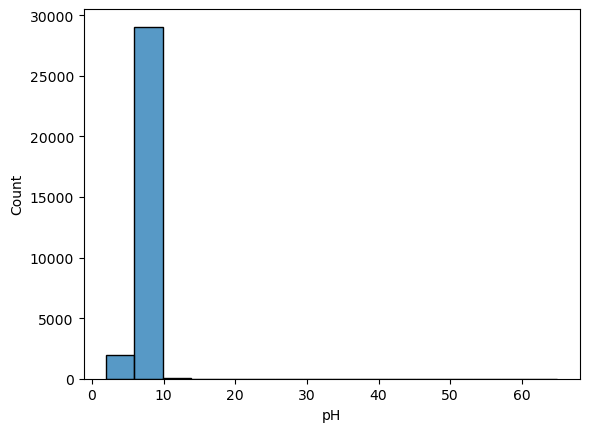

In [6]:
sns.histplot(novo['pH'])

This was unexpected. The pH seems to have a few outliers. Let's see which protein sequences have outlier pHs. If there are, we will need to decide what to do with it.

In [7]:
novo['pH'][novo['pH'] > 14].count()

28

Removing these 28 observations should not affect the quality of the model.

<AxesSubplot:xlabel='pH', ylabel='Count'>

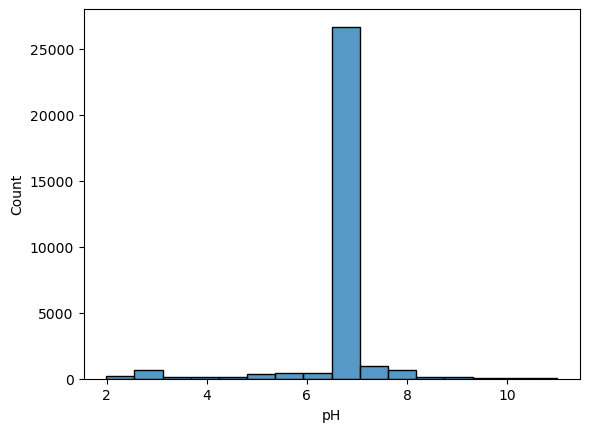

In [8]:
novo = novo[novo['pH'] < 14]
sns.histplot(novo['pH'])

Now we can add features using Biopython in order to create a more expressive model.

In [9]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

molecular_weight = []
gravy = []
flexibility = []
instability = []
sec_struct = []
mean_flexibility = []
aa_count = []
aa_perc = []

for index in novo.index:
    proto = ProteinAnalysis(novo['protein_sequence'].loc[index])
    molecular_weight.append(proto.molecular_weight())
    gravy.append(proto.gravy())
    flexibility.append(proto.flexibility())
    instability.append(proto.instability_index())
    sec_struct.append(proto.secondary_structure_fraction())
    aa_count.append(proto.count_amino_acids())
    aa_perc.append(proto.get_amino_acids_percent())


novo['molecular_weight'] = molecular_weight
novo['gravy'] = gravy
novo['flexibility'] = flexibility
novo['instability'] = instability
novo['secondary_structure_fraction'] = sec_struct
novo['amino_acid_count'] = aa_count
novo['amino_acid_percent'] = aa_perc

In [10]:
amino_pct = novo['amino_acid_percent'].apply(pd.Series)

In [26]:
novo_data = novo[['pH', 'molecular_weight', 'gravy', 'instability']]
novo_data = novo_data.merge(amino_pct, how='left', left_index=True, right_index=True)
novo_data['tm'] = novo['tm']

<AxesSubplot:>

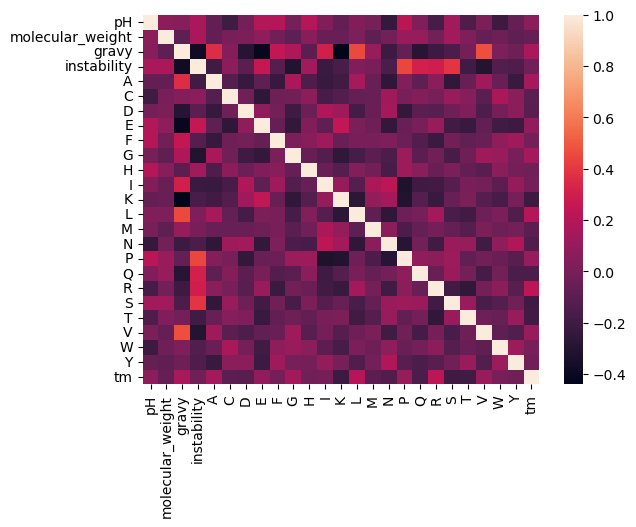

In [28]:
sns.heatmap(novo_data.corr())

The factors I want to include are as follows: pH, gravy, A, L, & R.

In [30]:
novo_mod_set = novo_data[['pH', 'gravy', 'A', 'L', 'R']]

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(novo_mod_set, novo_data['tm'], test_size=0.2)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))

mean_squared_error :  168.77042578852505
mean_absolute_error :  9.691943911288373


In [46]:
las = Lasso(alpha = 0.1)
las.fit(X_train, y_train)
y_pred = las.predict(X_test)
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))

mean_squared_error :  187.49584285919045
mean_absolute_error :  9.720498037276254


In [47]:
rdg = Ridge()
rdg.fit(X_train, y_train)
y_pred = rdg.predict(X_test)
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))

mean_squared_error :  168.89499435847958
mean_absolute_error :  9.664088674705804


Putting in the test data. Going for the ridge regression model.

In [56]:
Test_Set = pd.read_csv('test.csv')

Test_Set.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [59]:
gravy = []
aa_perc = []

for index in Test_Set.index:
    protein = ProteinAnalysis(Test_Set['protein_sequence'].loc[index])
    gravy.append(protein.gravy())
    aa_perc.append(protein.get_amino_acids_percent())

Test_Set['gravy'] = gravy
Test_Set['amino_acid_percent'] = aa_perc

test_amino = Test_Set['amino_acid_percent'].apply(pd.Series)

Test_Set = Test_Set[['pH', 'gravy']]
Test_Set = Test_Set.merge(test_amino, how='left', left_index=True, right_index=True)
Test_Set = Test_Set[['pH', 'gravy', 'A', 'L', 'R']]

KeyError: 'protein_sequence'

In [64]:
y_pred = rdg.predict(Test_Set)
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(inplace=True)
y_pred.rename(columns={'index':'seq_id', 0:'tm'})
y_pred.to_csv('results.csv', index = False, header = ['seq_id', 'tm'])